# CLIP
[Ссылка на исходный Colab-блокнот](https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb)

Блокнот показывает, как загрузить и запустить модели CLIP, вычислить схожесть между произвольными изображениями и текстовыми входами, а также выполнить zero-shot классификацию изображений.

# Подготовка для Colab

Убедитесь, что используете GPU runtime

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-eizr29mp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-eizr29mp
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=ed42fdd08d7472bfb350dbe85e3811e7022228735c4e66f9e1e83e95dd72c3e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-w_as0qol/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


/tmp/ipython-input-189856270.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


Torch version: 2.9.0+cu126


# Загрузка модели

`clip.available_models()` выведет список названий доступных моделей CLIP.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 260MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Предобработка изображений

Изменим размер входных изображений и обрежем их по центру, чтобы соответствовать разрешению изображения, которое ожидает модель. Перед этим нормализуем интенсивность пикселей, используя среднее значение и стандартное отклонение набора данных.

Второе возвращаемое значение из `clip.load()` содержит `Transform` из torchvision, который выполняет эту предобработку.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7a875f982520>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Предобработка текста

Применим токенизатор без учета регистра, который можно вызвать с помощью `clip.tokenize()`. По умолчанию выходы дополняются до 77 токенов, что ожидают модели CLIP.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Настройка входных изображений и текстов

Мы собираемся подать 8 примеров изображений и их текстовые описания в модель и сравнить схожесть между соответствующими признаками.

Токенизатор не чувствителен к регистру, и мы можем свободно давать любые подходящие текстовые описания.

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [8]:
skimage.data.download_all()

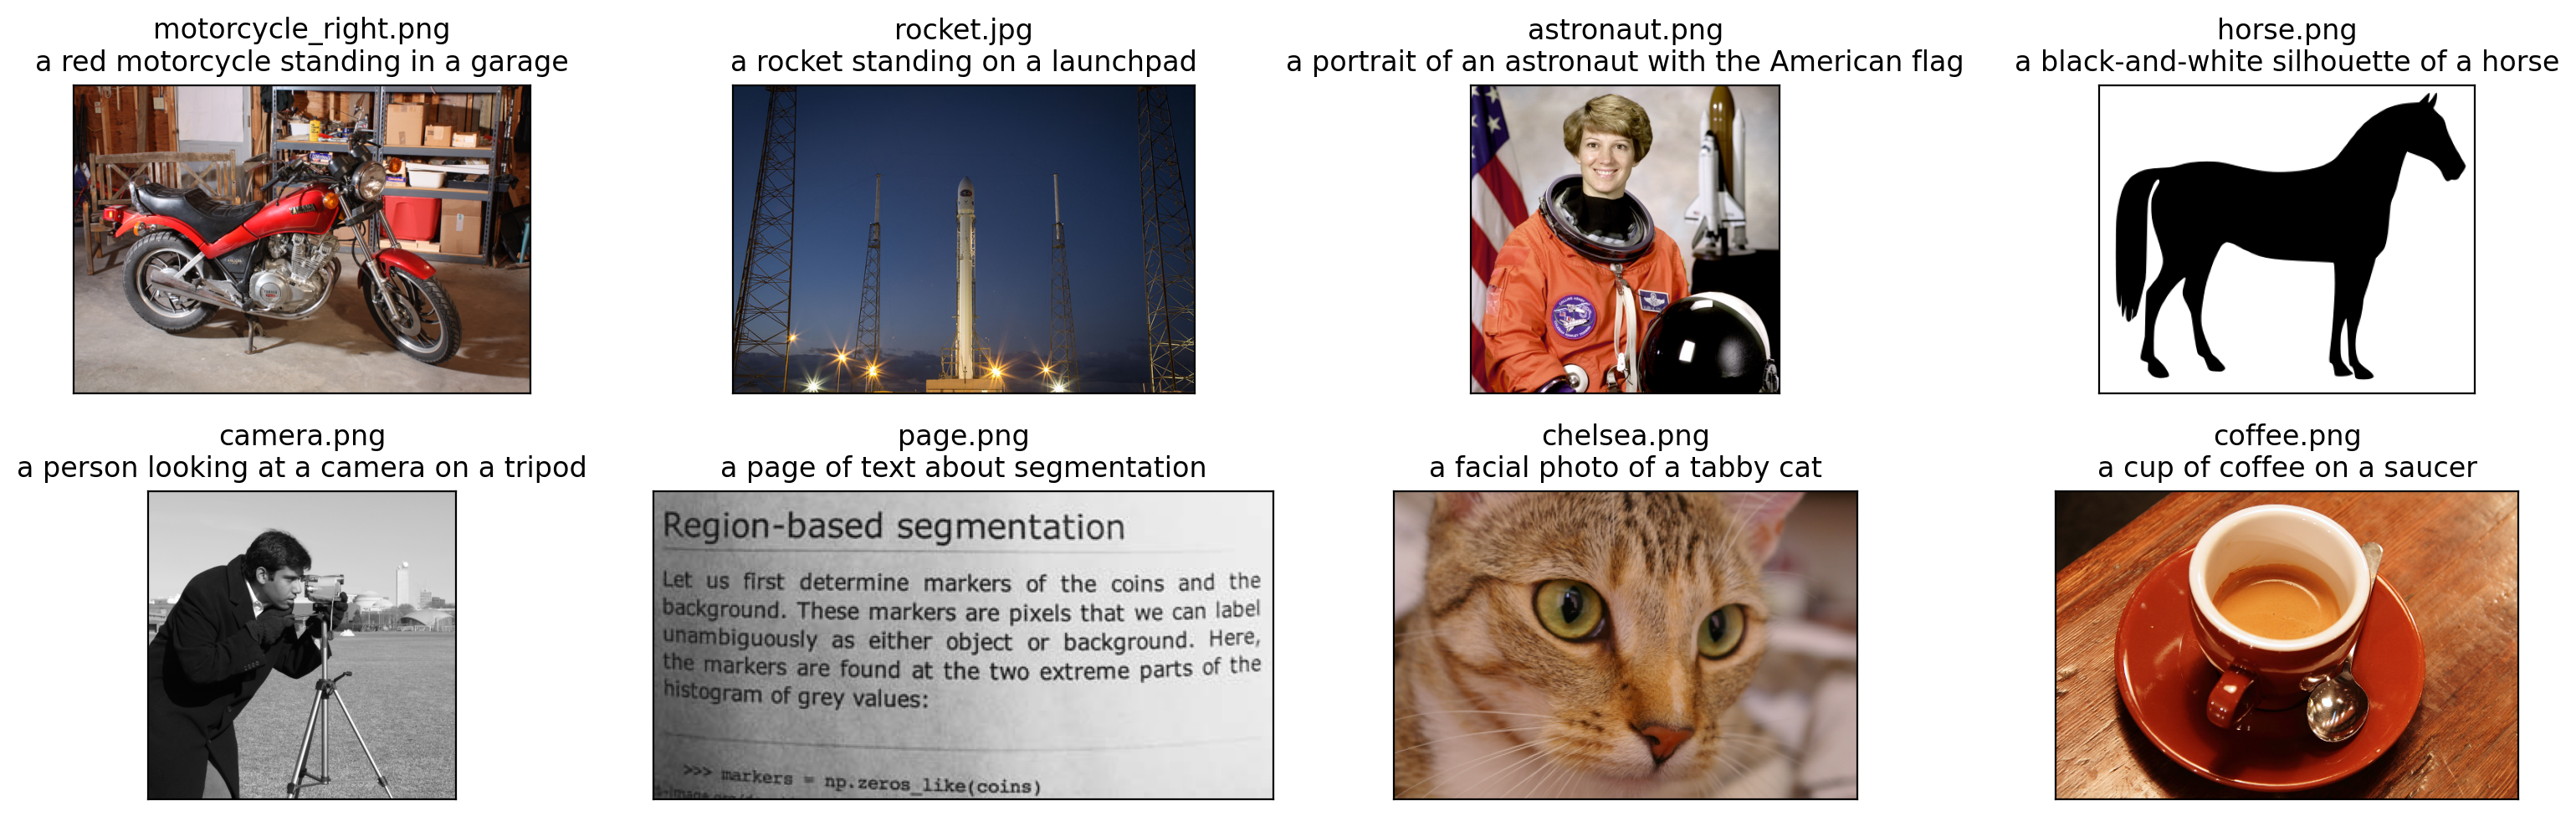

In [9]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Построение признаков

Нормализуем изображения, токенизируем каждый текстовый вход и запустим прямой проход модели для получения признаков изображений и текста.

In [10]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [11]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Вычисление косинусного сходства

Нормализуем признаки и вычислим скалярное произведение каждой пары.

In [12]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

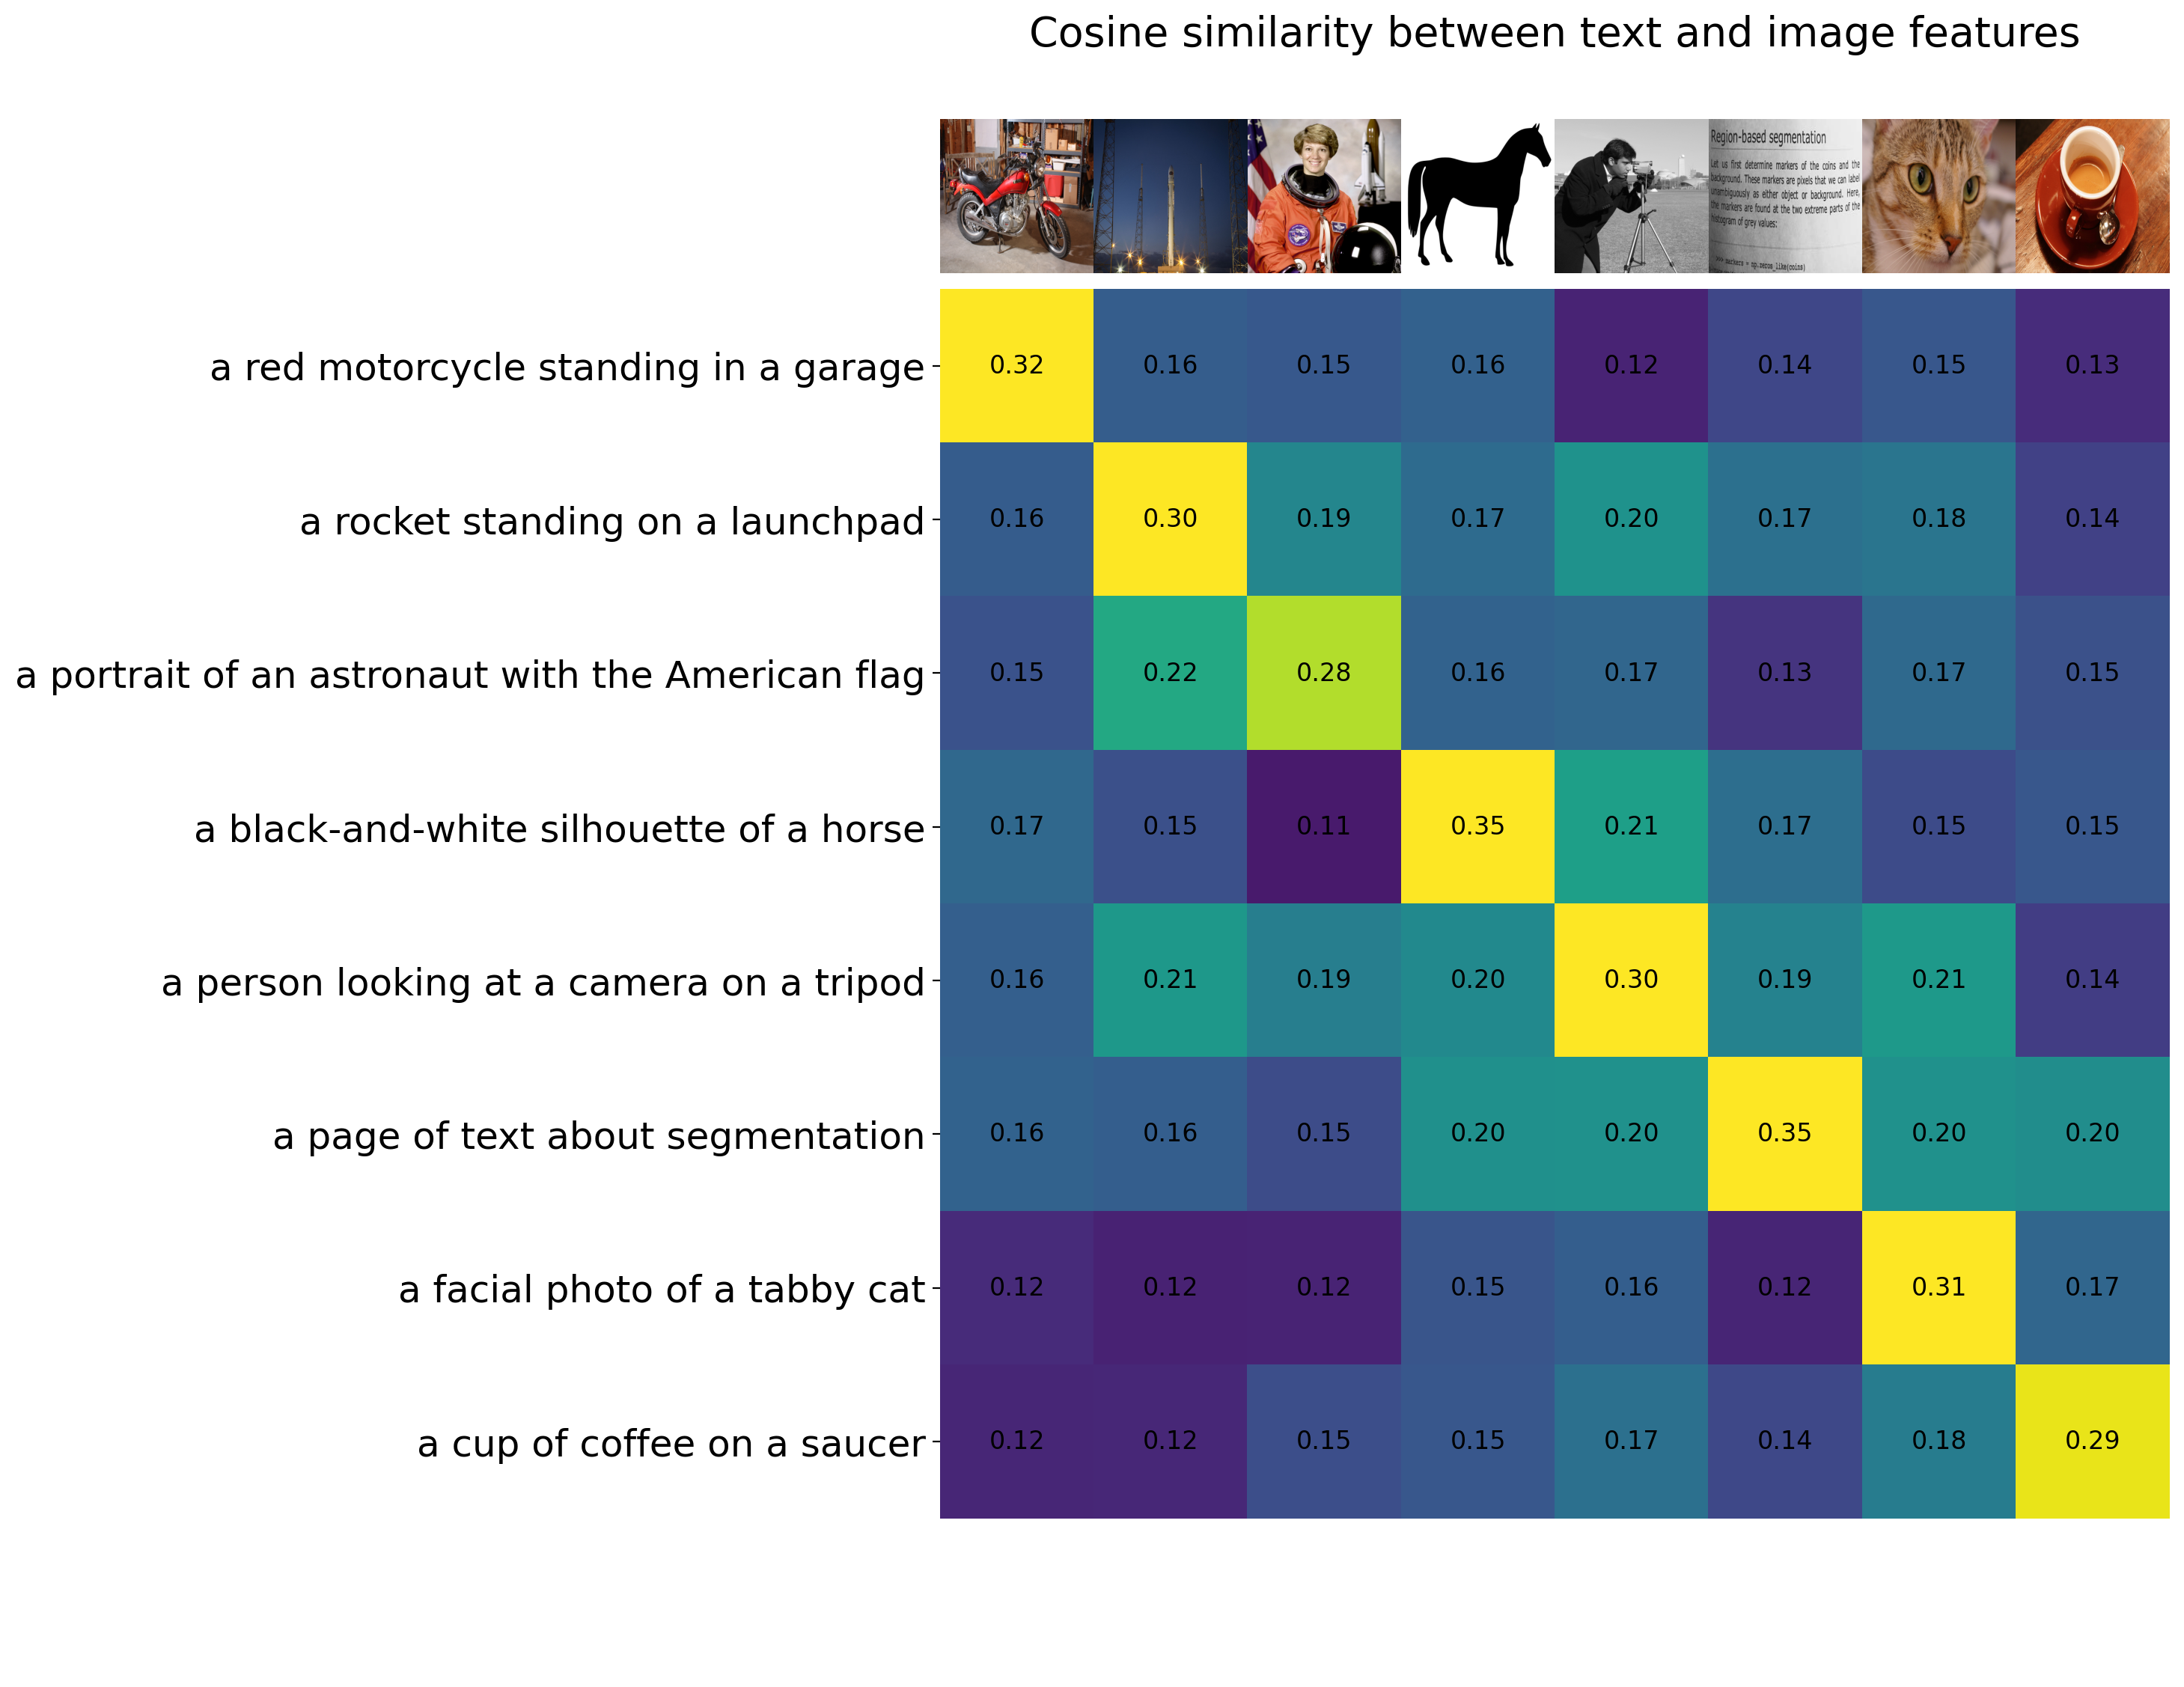

In [13]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot классификация изображений

Можно классифицировать изображения, используя косинусное сходство (умноженное на 100) в качестве логитов для операции softmax.

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, train=False, download=True)

100%|██████████| 169M/169M [00:13<00:00, 12.4MB/s]


In [16]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [17]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

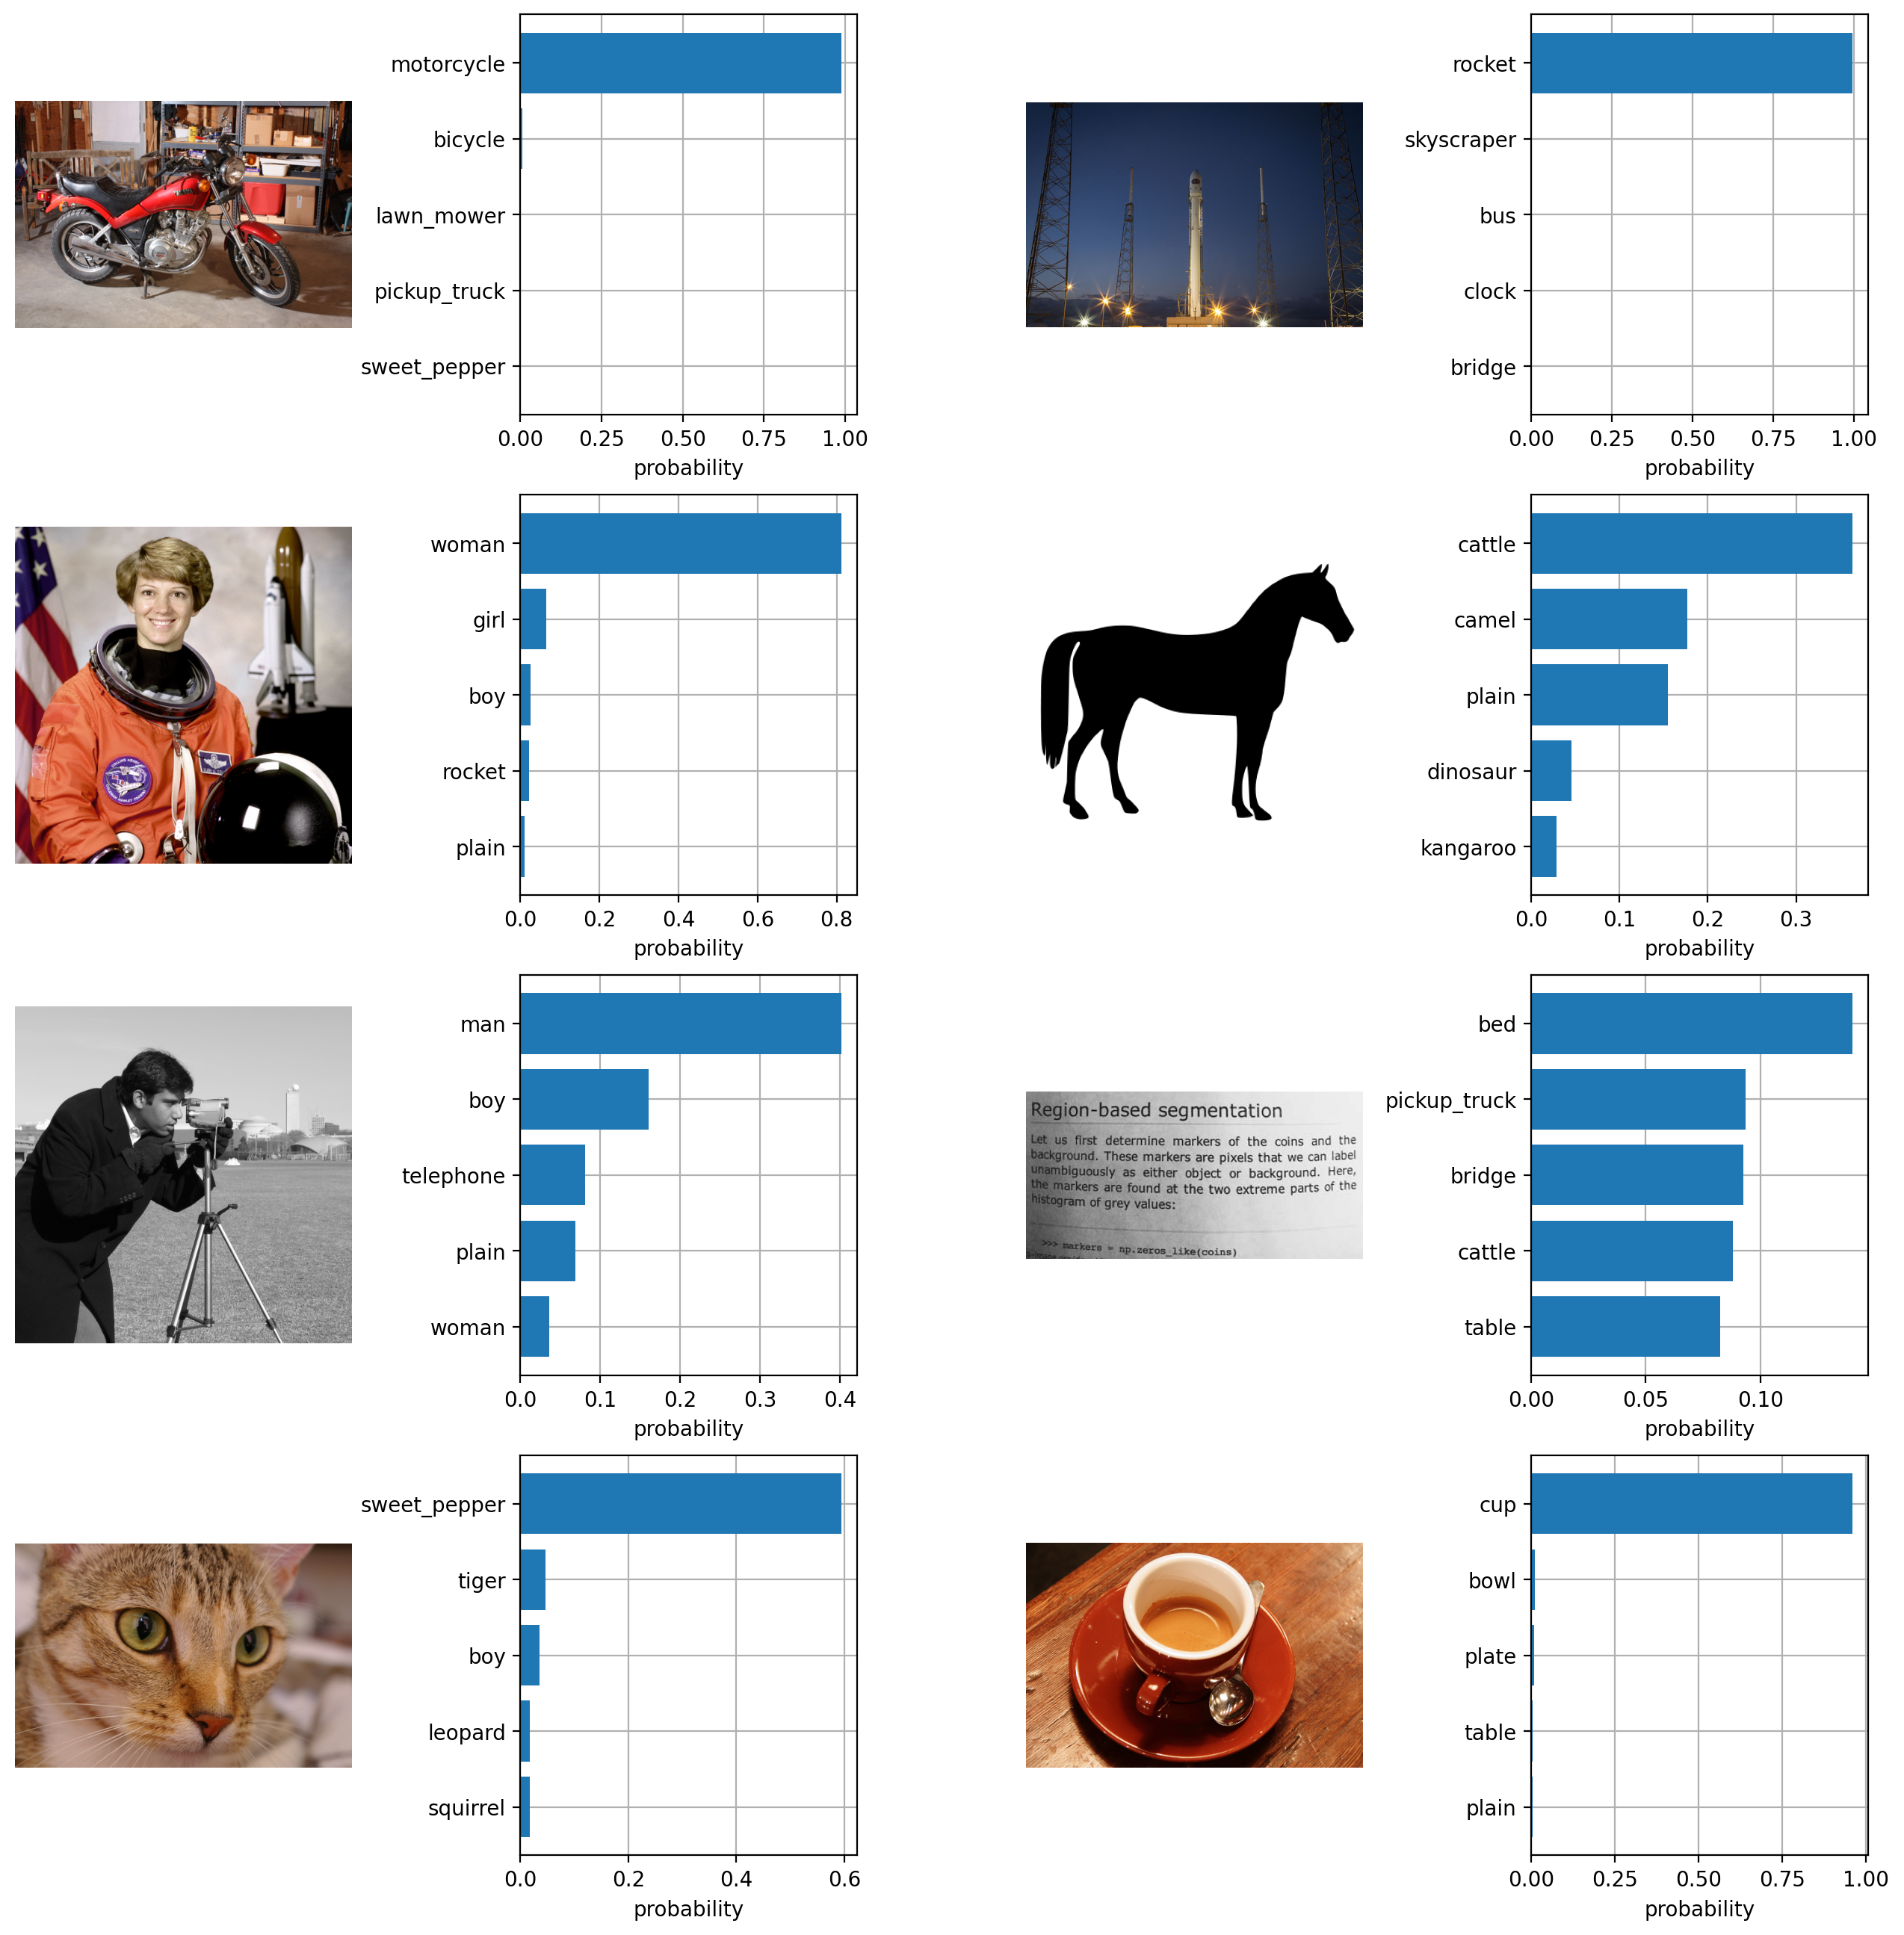

In [18]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [20]:
from torch.utils.data import DataLoader

In [21]:
all_top_labels = []

for images, labels_batch in DataLoader(cifar100, batch_size=64):
    images = images.cuda()
    with torch.no_grad():
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        _, top_labels = text_probs.cpu().topk(5, dim=-1)
        all_top_labels.append(top_labels)

all_top_labels = torch.cat(all_top_labels, dim=0)
labels = torch.tensor([label for _, label in cifar100])

top1_CLIP = (all_top_labels[:, 0] == labels).float().mean().item()

top5_CLIP = torch.tensor([labels[i] in all_top_labels[i] for i in range(len(labels))]).float().mean().item()

print(f"CLIP Top-1 Accuracy: {top1_CLIP:.4f}")
print(f"CLIP Top-5 Accuracy: {top5_CLIP:.4f}")

CLIP Top-1 Accuracy: 0.5821
CLIP Top-5 Accuracy: 0.8492


# Сравним с CNN:

In [34]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [35]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_dataset = CIFAR100(root=os.path.expanduser("~/.cache"), train=True, transform=train_transform, download=True)
test_dataset = CIFAR100(root=os.path.expanduser("~/.cache"), train=False, transform=test_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)



In [36]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [37]:
cnn_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

scaler = torch.cuda.amp.GradScaler()
num_epochs = 25

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader.dataset):.4f}")

/tmp/ipython-input-3475823690.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-3475823690.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/25, Loss: 3.6659
Epoch 2/25, Loss: 2.8393
Epoch 3/25, Loss: 2.4006
Epoch 4/25, Loss: 2.1198
Epoch 5/25, Loss: 1.9297
Epoch 6/25, Loss: 1.7747
Epoch 7/25, Loss: 1.6589
Epoch 8/25, Loss: 1.5581
Epoch 9/25, Loss: 1.4668
Epoch 10/25, Loss: 1.3956
Epoch 11/25, Loss: 1.3192
Epoch 12/25, Loss: 1.2690
Epoch 13/25, Loss: 1.2138
Epoch 14/25, Loss: 1.1521
Epoch 15/25, Loss: 1.1089
Epoch 16/25, Loss: 1.0715
Epoch 17/25, Loss: 1.0253
Epoch 18/25, Loss: 0.9864
Epoch 19/25, Loss: 0.9543
Epoch 20/25, Loss: 0.9184
Epoch 21/25, Loss: 0.8858
Epoch 22/25, Loss: 0.8506
Epoch 23/25, Loss: 0.8241
Epoch 24/25, Loss: 0.7955
Epoch 25/25, Loss: 0.7736


In [38]:
def accuracy_topk(model, loader, k=1):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            topk = outputs.topk(k, dim=1).indices
            correct += (topk == labels.view(-1,1)).sum().item()
            total += labels.size(0)
    return correct / total

In [39]:
top1_CNN = accuracy_topk(cnn_model, test_loader, k=1)
top5_CNN = accuracy_topk(cnn_model, test_loader, k=5)

print(f"CNN Top-1 Accuracy: {top1_CNN:.4f}")
print(f"CNN Top-5 Accuracy: {top5_CNN:.4f}")

CNN Top-1 Accuracy: 0.6663
CNN Top-5 Accuracy: 0.8998
